In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import transform_strokes, inverse_transform_strokes, get_n_points
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Encoder, Decoder, EncoderDecoder
from lib.model import train, evaluate, reconstruction_loss
from lib.model import extract_start_of_stroke, generate

# Load and show dataset

In [156]:
dataset_name = 'effeil'

In [157]:
dataset = unpack_drawings(f'./data/{dataset_name}.bin')
dataset = list(dataset)

In [158]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

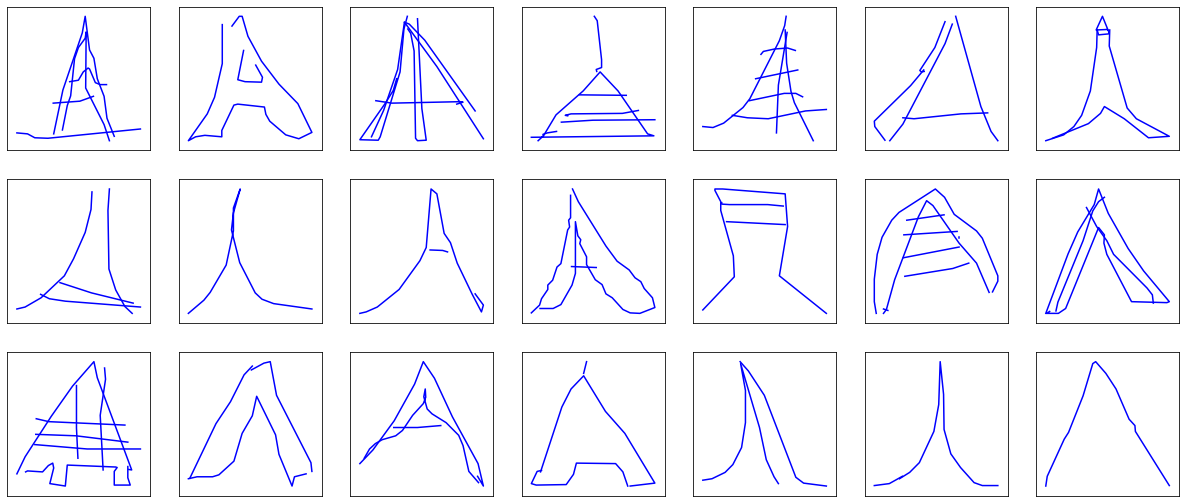

In [159]:
fig, axarr = get_canvas(3, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

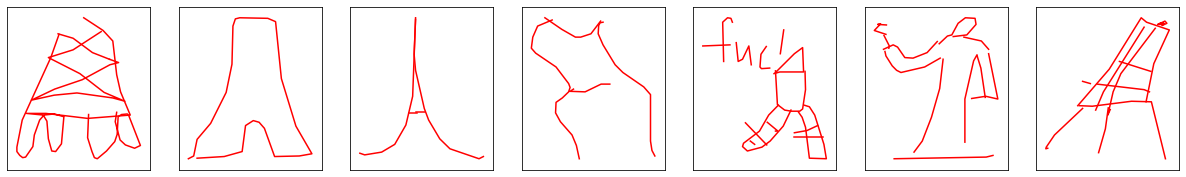

In [160]:
fig, axarr = get_canvas(1, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [161]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [162]:
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'delta_y')

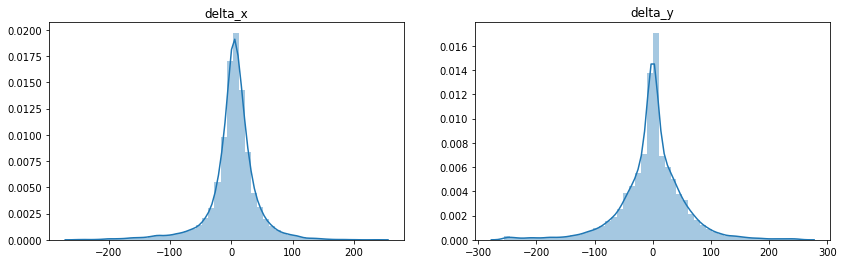

In [163]:
# Transformed stroke coordinates follow a gaussian distribution.

transformed_drawings = [transform_strokes(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

# Create pytorch dataset

In [164]:
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transform_strokes(drawing) for drawing in drawings]

In [165]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [166]:
ds = get_dataset(transformed_drawings)

In [167]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.01)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(956, 344)

In [168]:
train_means_stds = get_means_stds(train_ds)
val_means_stds = get_means_stds(val_ds)

In [17]:
# Debug batches generation

train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lengths_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lengths_batch):
    print(tensor)
    print()

torch.Size([173, 2, 5]) torch.Size([173, 2, 5]) torch.Size([2])


tensor([[[-0.1990, -0.2908,  1.0000,  0.0000,  0.0000],
         [-0.2860,  0.3968,  1.0000,  0.0000,  0.0000]],

        [[-0.4600, -0.0845,  1.0000,  0.0000,  0.0000],
         [ 0.4969,  1.2563,  1.0000,  0.0000,  0.0000]],

        [[-0.4600,  0.0530,  1.0000,  0.0000,  0.0000],
         [ 0.6999,  0.0187,  1.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])

tensor([[[-0.4600, -0.0845,  1.0000,  0.0000,  0.0000],
         [ 0.4969,  1.2563,  1.0000,  0.0000,  0.0000]],

        [[-0.4600,  0.0530,  1.0000,  0.0000,  0.0000],
         [ 0.6999,  0.0187,  1.0000,  0.0000,  0.0000]],

       

In [18]:
# Debug model forward

model = Decoder(dim_hidden=5, n_gaussians=3)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_means_stds, batch_size=1024)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

gmm_params, strokes_state_params, lstm_states = model(data_batch, lengths_batch)

TypeError: __init__() missing 1 required positional argument: 'dim_input'

In [ ]:
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
hidden_state, cell_state = lstm_states

print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)

print(strokes_state_params.shape)

print(hidden_state.shape, cell_state.shape)

In [ ]:
# Debug loss
reconstruction_loss(gmm_params, strokes_state_params, labels_batch, lengths_batch)

In [ ]:
# Debug generation
start_of_stroke = extract_start_of_stroke(train_ds, n_points=2)
generate(model, start_of_stroke, n_points=3)

In [32]:
dec_dim_hidden = 18
n_gaussians = 4

conditional = False

if conditional:

    enc_dim_hidden = 3
    dim_latent = 5
    
    encoder = Encoder(5, enc_dim_hidden, dim_latent)
    decoder = Decoder(dim_latent + 5, dec_dim_hidden, n_gaussians)

    model = EncoderDecoder(encoder, decoder)

else:
    model = Decoder(5, dec_dim_hidden, n_gaussians)

model

Decoder(
  (lstm): LSTM(5, 18)
  (output_weights): Linear(in_features=18, out_features=27, bias=True)
)

In [33]:
gmm_params, strokes_state_params, lstm_states = model(data_batch, lengths_batch)

In [34]:
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
hidden_state, cell_state = lstm_states

print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)

print(strokes_state_params.shape)

print(hidden_state.shape, cell_state.shape)

torch.Size([71, 2, 4])
torch.Size([71, 2, 4]) torch.Size([71, 2, 4])
torch.Size([71, 2, 4]) torch.Size([71, 2, 4]) torch.Size([71, 2, 4])
torch.Size([71, 2, 3])
torch.Size([1, 2, 18]) torch.Size([1, 2, 18])


In [35]:
isinstance(model, EncoderDecoder)

False

In [36]:
if conditional:
    idx = 0
    data = data_batch[:, idx, :].unsqueeze(1)
    length = lengths_batch[idx]
    initial_points = data[:length + 1, :, :]
else:
    initial_points = extract_start_of_stroke(train_ds, n_points=2)

generate(model, initial_points, n_points=3)

unconditional


tensor([[ 0.0040, -0.1876,  1.0000,  0.0000,  0.0000],
        [-0.8949, -0.2220,  1.0000,  0.0000,  0.0000],
        [ 0.1645, -0.0212,  0.0000,  1.0000,  0.0000],
        [ 0.1589, -0.0219,  0.0000,  1.0000,  0.0000],
        [-0.0566, -0.9926,  1.0000,  0.0000,  0.0000]])

# Train

In [38]:
batch_size = 64
dim_hidden = 128
n_gaussians = 20

model = Decoder(5, dim_hidden, n_gaussians)
if torch.cuda.is_available():
    model = model.cuda()

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [39]:
print(model)

Decoder(
  (lstm): LSTM(5, 128)
  (output_weights): Linear(in_features=128, out_features=123, bias=True)
)


In [40]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=300, epochs_between_evals=10)

epoch:   1   train_loss: 3.82084   val_loss: 3.83986
epoch:  10   train_loss: 3.55335   val_loss: 3.60541


KeyboardInterrupt: 

In [79]:
torch.save(model.state_dict(), f'models/{dataset_name}.pth')

# Predict

In [169]:
dataset_name = 'effeil'

In [170]:
model_name = dataset_name
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(f'./models/{dataset_name}.pth', map_location=map_location))

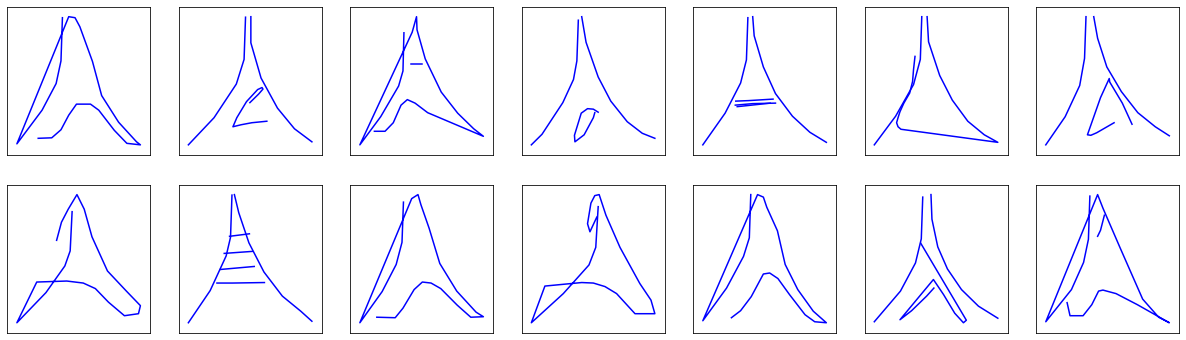

In [195]:
temperature = 0.1

fig, axarr = get_canvas(2, 7)

start_of_stroke = extract_start_of_stroke(val_ds, n_points=1)

if torch.cuda.is_available():
    start_of_stroke = start_of_stroke.cuda()

all_preds_strokes = []
for i, ax in enumerate(axarr.flatten()):
    pred_flat_strokes = generate(model, start_of_stroke, n_points=20, temperature=temperature)
    pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
    pred_strokes = inverse_transform_strokes(pred_flat_strokes)
    all_preds_strokes.append(pred_strokes)
    plot(pred_strokes, color='b', ax=ax)

In [172]:
%%capture
pred_anim = get_animation(all_preds_strokes[0])

In [173]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [174]:
pred_anim.save('generated.gif', dpi=80, writer='imagemagick')